# Reproducing results from Pahitariu et al. 2024

In [117]:
# Imports
import sys

sys.path.append("../../stork")

import stork

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm

# change default color cycler
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=cm.batlow(np.linspace(0, 1, 10)))


from utils.utils import *

from scipy.stats import linregress
from sklearn.decomposition import PCA

from pydmd.plotter import plot_modes_2D
from pydmd import DMD, BOPDMD
from pydmd.plotter import plot_eigs, plot_summary
from pydmd.preprocessing import hankel_preprocessing

In [118]:
# for reproducibility
np.random.seed(2025)

In [119]:
# Simulation parameters
dt = timestep = 2e-3  # timestep in s
duration = 60  # Duration in seconds

nb_steps = int(duration / dt)
tau = 50e-3

N = 2500

symmetric = False

In [120]:
weights = np.random.normal(size=(N, N))
weights -= np.mean(weights)

if symmetric:
    weights += weights.T
    # set the diagonal to 0

np.fill_diagonal(weights, 0)


print(np.mean(weights))

-4.930526548977532e-06


In [121]:
weights -= np.mean(weights)
print(np.mean(weights))

-2.4283508537337183e-18


In [122]:
# Compute the current spectral radius
current_spectral_radius = np.max(np.abs(np.linalg.eigvals(weights)))
print(f"Old spectral radius: {current_spectral_radius}")

# Scale the weights
desired_spectral_radius = 0.999
scaling_factor = desired_spectral_radius / current_spectral_radius
weights *= scaling_factor

# Verify the new spectral radius
new_spectral_radius = np.max(np.abs(np.linalg.eigvals(weights)))
print(f"New spectral radius: {new_spectral_radius}")

Old spectral radius: 50.846949368929295
New spectral radius: 0.9989999999999971


## Analyse weight matrix

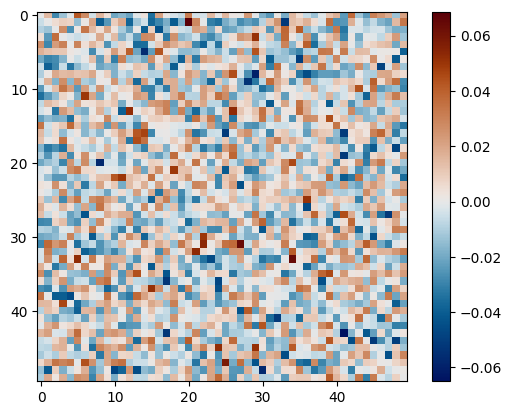

In [123]:
im = plt.imshow(weights[:50, :50], cmap=cm.vik)
plt.colorbar(im)

In [124]:
eig_w = np.linalg.eigvals(weights)

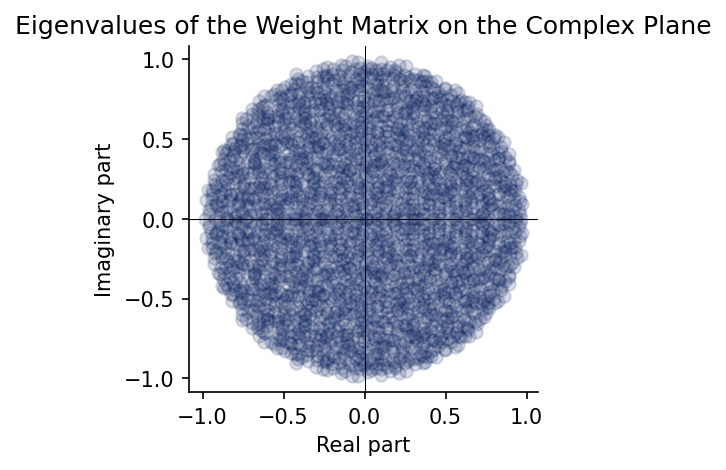

In [125]:
plt.figure(figsize=(3, 3), dpi=150)

if symmetric:
    plt.hist(eig_w, edgecolor="white", alpha=0.75, bins=30, density=True)
    plt.xlabel("eig w")
    plt.ylabel("density")

else:
    # Plot the eigenvalues on the complex plane
    plt.scatter(eig_w.real, eig_w.imag, alpha=0.15, edgecolor=None)
    plt.axhline(0, color="black", lw=0.5)
    plt.axvline(0, color="black", lw=0.5)
    plt.xlabel("Real part")
    plt.ylabel("Imaginary part")
    plt.title("Eigenvalues of the Weight Matrix on the Complex Plane")

sns.despine()
plt.show()

## Run dynamics

$\tau \dot{x } = -x + Ax +\epsilon$

In [126]:
print(dt/tau)


0.04


In [127]:
# Simulation
orig_states = np.zeros((nb_steps, N))

for t in trange(nb_steps):
    x = orig_states[t - 1]
    epsilon = np.random.normal(size=N) * dt / tau
    inp = weights.T @ x * dt / tau

    x_new = x - dt / tau * x + inp + epsilon

    orig_states[t] = x_new

100%|██████████| 30000/30000 [02:26<00:00, 204.61it/s]


discard first few time steps of the states

In [128]:
states = orig_states.copy()

In [129]:
print(states.shape)
n_discard = 8000
states = states[n_discard:]
print(states.shape)

(30000, 2500)
(22000, 2500)


In [130]:
# # normalize activity
# states = (states - np.mean(states))*2/(np.max(states)-np.min(states))

# print(np.min(states), np.max(states))

# print(states.shape)
# for i, state in enumerate(states.T):
#     states[:, i] =(state-np.mean(state))/np.std(state)

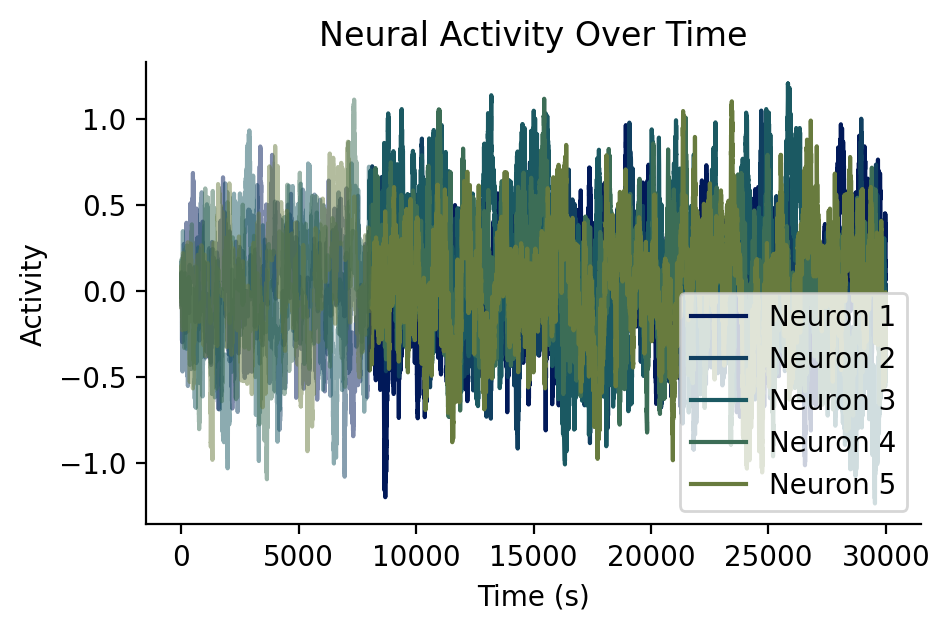

In [131]:
# Plot the first few neurons' activity over time
plt.figure(figsize=(5, 3), dpi=200)
for i in range(5):
    plt.plot(np.arange(n_discard, nb_steps), states[:, i], label=f"Neuron {i+1}")

# reset color cycler
plt.gca().set_prop_cycle(None)
for i in range(5):
    plt.plot(np.arange(n_discard), orig_states[:n_discard, i],  alpha=0.5)
plt.xlabel("Time (s)")
plt.ylabel("Activity")
plt.title("Neural Activity Over Time")
plt.legend()
sns.despine()
plt.show()

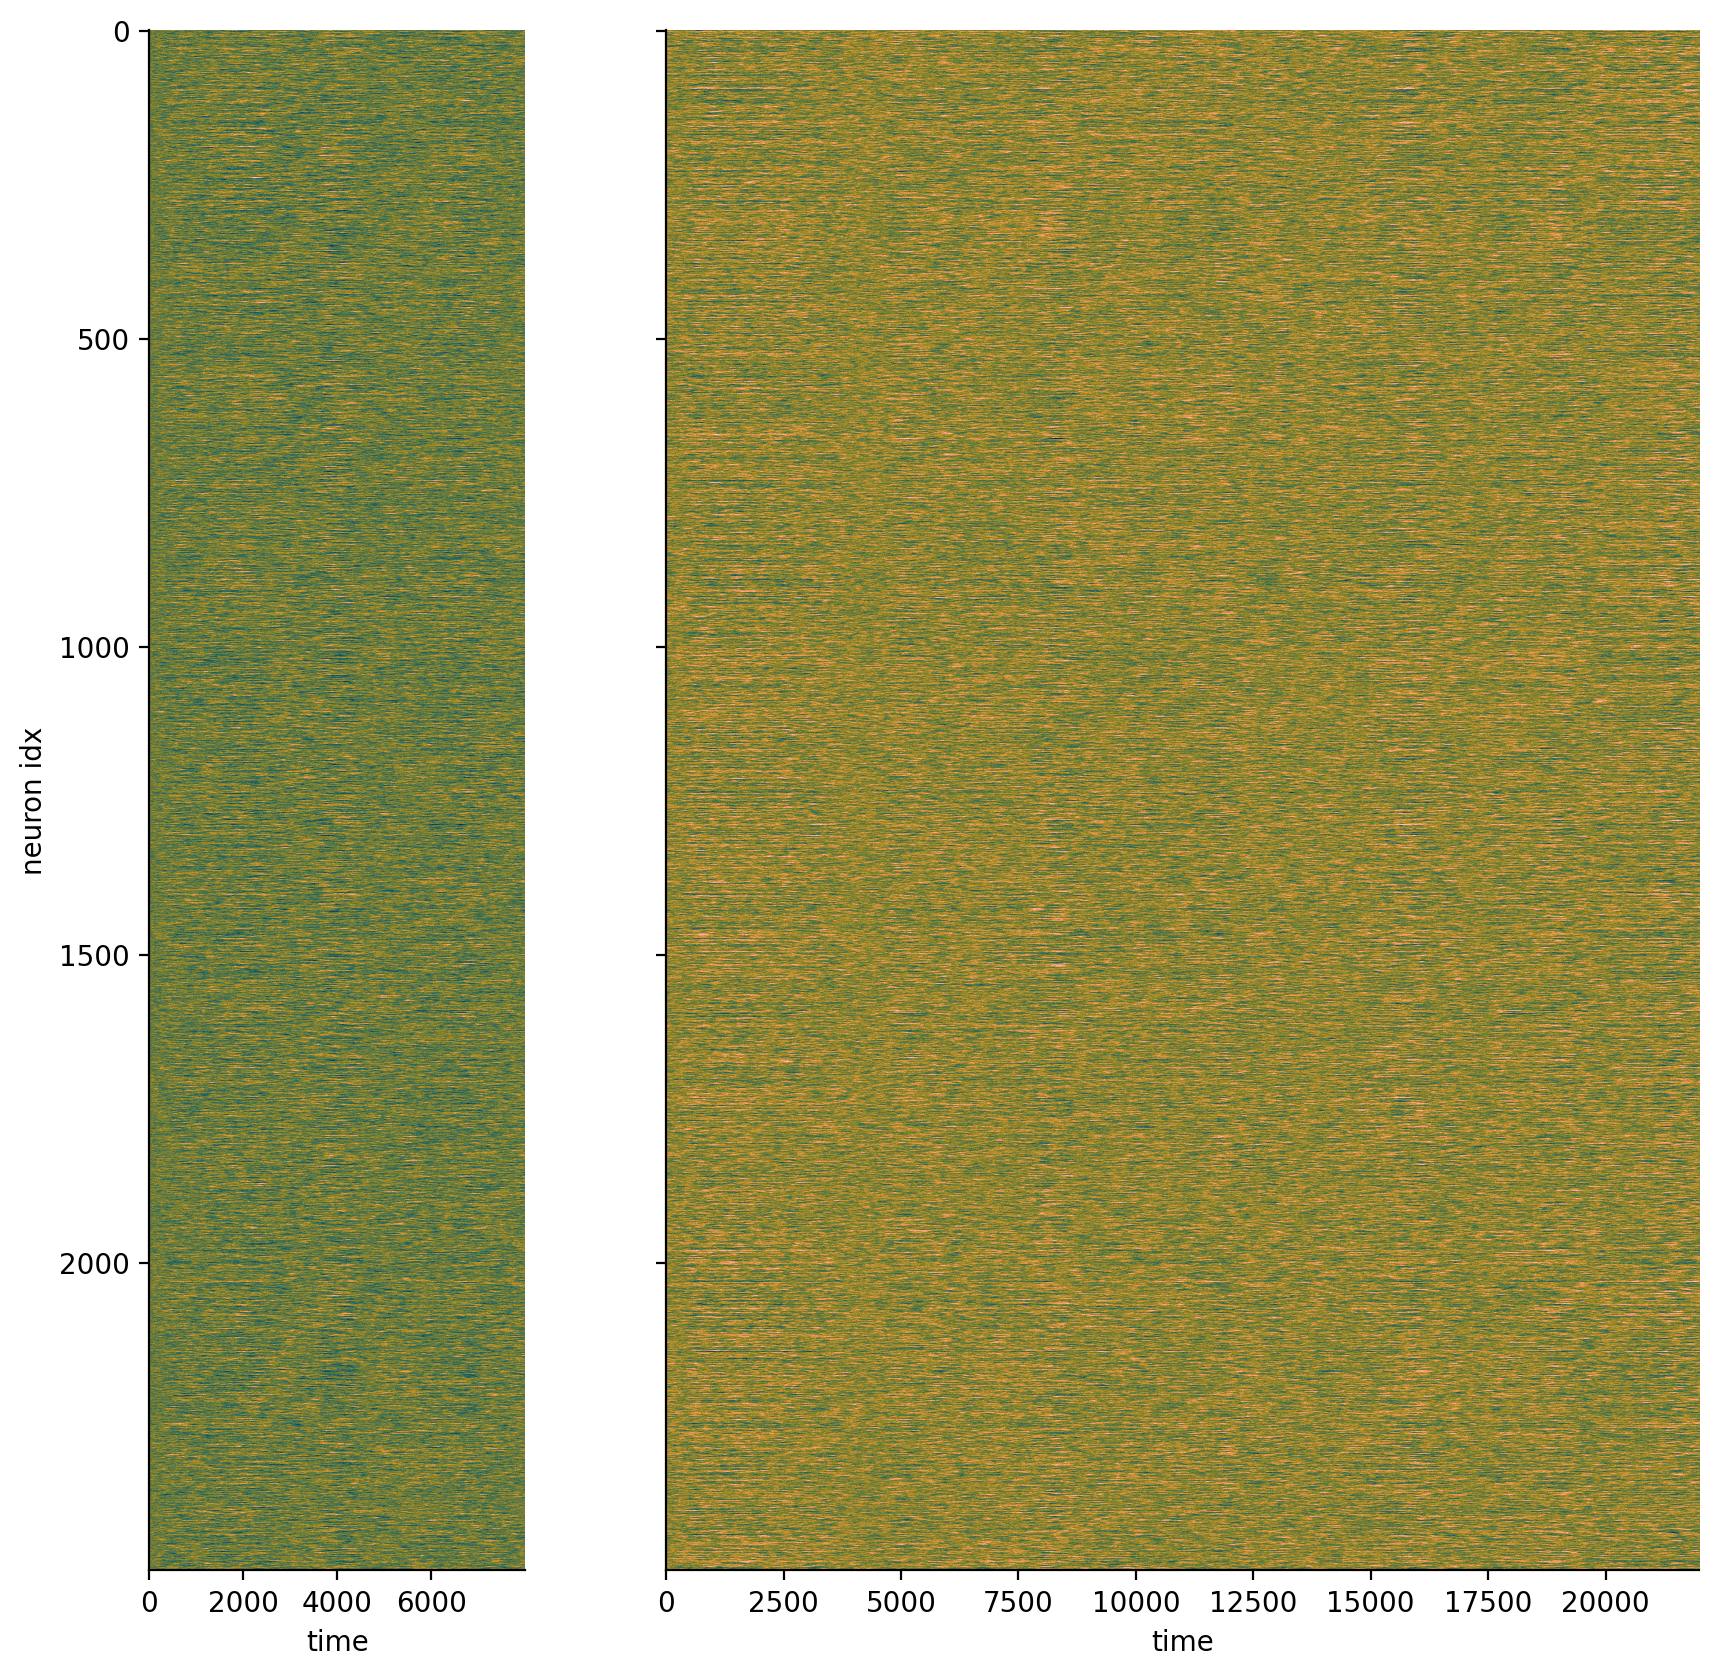

In [132]:
fig, ax = plt.subplots(1,2,figsize=(10,10), dpi=200, gridspec_kw={"width_ratios": [n_discard, nb_steps-n_discard]}, sharey=True)
ax[0].imshow(orig_states[:n_discard].T, aspect="auto", cmap=cm.batlow, interpolation="nearest")
ax[1].imshow(states.T, aspect="auto", cmap=cm.batlow, interpolation="nearest")
ax[0].set_xlabel("time")
ax[1].set_xlabel("time")
ax[0].set_ylabel("neuron idx")
sns.despine()

In [133]:
print(states.shape)

(22000, 2500)


In [134]:
if False:
    # https://pydmd.github.io/PyDMD/tutorial1dmd.html


    d = 2
    neuron_space = np.linspace(0, N+1, N)
    time_space = np.linspace(0, nb_steps+1, nb_steps)
    print(neuron_space)

    # Build the Optimized DMD model.
    # num_trials=0 gives Optimized DMD, without bagging.
    optdmd = BOPDMD(svd_rank=20, num_trials=0)

    # Wrap the model with the preprocessing routine.
    delay_optdmd = hankel_preprocessing(optdmd, d=d)

    # Fit the model to the noisy data.
    # Note: BOPDMD models need the data X and the times of data collection t for fitting.
    # Hence if we apply time-delay, we must adjust the length of our time vector accordingly.
    delay_t = time_space[: -d + 1]
    delay_optdmd.fit(states.T, t=delay_t)

    # Plot a summary of the DMD results.
    plot_summary(delay_optdmd, x=neuron_space, d=d)

    # Print computed eigenvalues (frequencies are given by imaginary components).
    # Also plot the resulting data reconstruction.
    print(
        f"Frequencies (imaginary component): {np.round(delay_optdmd.eigs, decimals=3)}"
    )
    plt.title("Reconstructed Data")
    plt.imshow(delay_optdmd.reconstructed_data.real)
    plt.show()
    plt.title("Clean Ground Truth Data")
    plt.imshow(states.T)
    plt.show()

/home/gygajuli/miniconda3/envs/stork/lib/python3.11/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'dpi'
  cset = contour_func(


Text(12.722222222222223, 0.5, 'Neuron 2')

<Figure size 400x400 with 0 Axes>

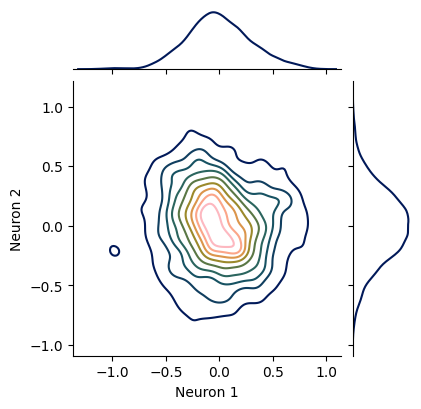

In [135]:
# Create a DataFrame for seaborn
data = {"Neuron 1": states[:, 0], "Neuron 2": states[:, 1]}
df = pd.DataFrame(data)

# Plot the density plot
plt.figure(figsize=(4, 4))
sns.jointplot(
    x=data["Neuron 1"],
    y=data["Neuron 2"],
    kind="kde",
    cmap=cm.batlow,
    height=4,
    ratio=4,
    dpi=250,
    palette=cm.batlow,
)

plt.xlabel("Neuron 1")
plt.ylabel("Neuron 2")

22 Hz sampling from data that is simulated at 500 Hz

In [136]:
# Define the bin size
bin_size = 22

# Calculate the number of bins
num_bins = states.shape[0] // bin_size

# Initialize the binned states array
binned_states = np.zeros((num_bins, states.shape[1]))

# Bin the states
for i in range(num_bins):
    binned_states[i] = np.mean(states[i*bin_size:(i+1)*bin_size], axis=0)

print(binned_states.shape)

(1000, 2500)


In [137]:
# Define the bin size
bin_size = 22

# Calculate the number of bins
num_bins = states.shape[0] // bin_size

# Initialize the binned states array
binned_states = np.zeros((num_bins, states.shape[1]))

# Bin the states
for i in range(num_bins):
    binned_states[i] = np.mean(states[i*bin_size:(i+1)*bin_size], axis=0)

print(binned_states.shape)

(1000, 2500)


In [138]:
ds_states = states.copy()
ds_states = ds_states[::22]

print(ds_states.shape)

(1000, 2500)


In [139]:
activity = binned_states

Text(0, 0.5, 'neuron')

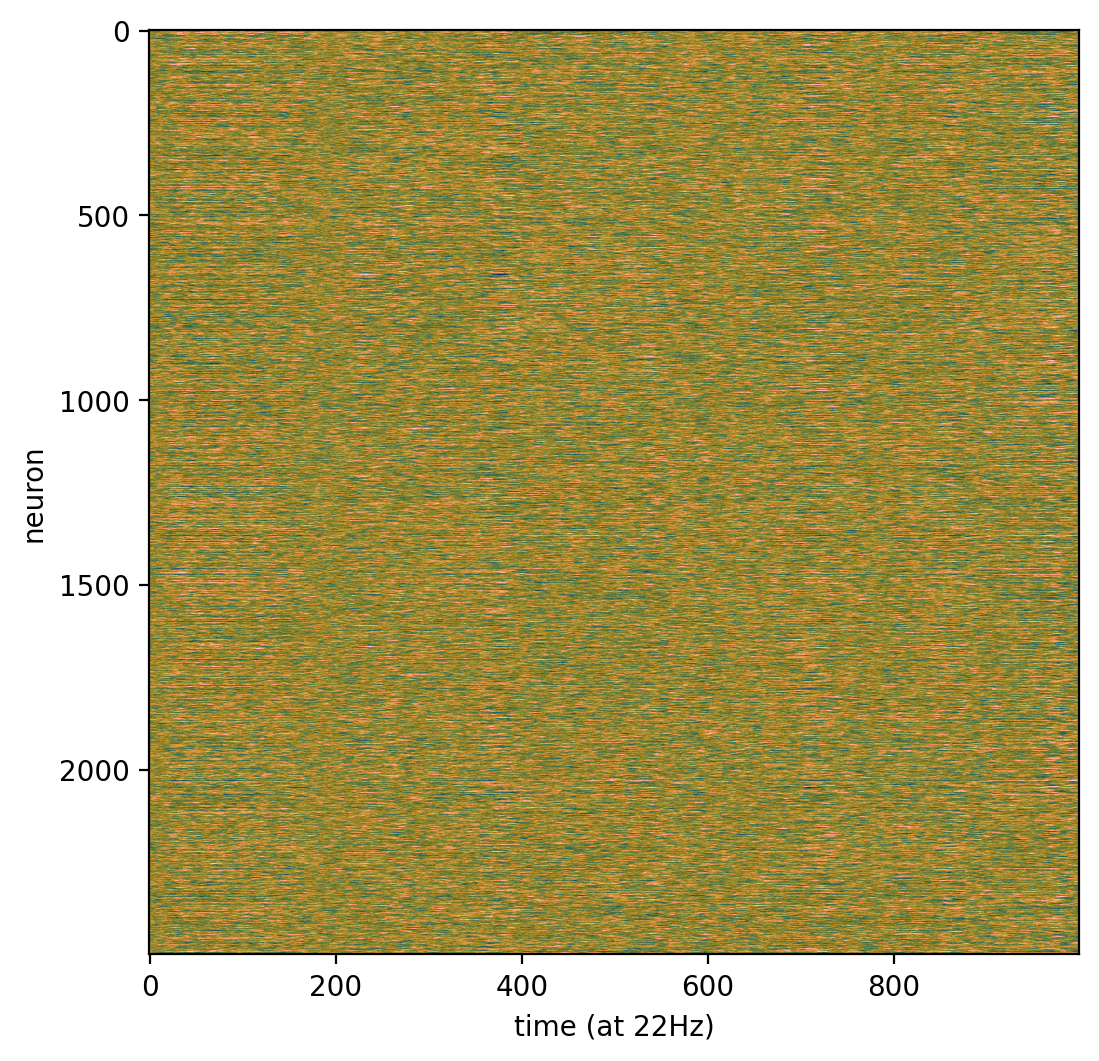

In [140]:
plt.figure(figsize=(6,6), dpi=200)
plt.imshow(activity.T, aspect="auto", interpolation="nearest", cmap=cm.batlow)
plt.xlabel("time (at 22Hz)")
plt.ylabel("neuron")

In [141]:
cov_matrix = np.cov(activity.T)

print(cov_matrix.shape)

(2500, 2500)


In [142]:
eig_cov = sorted(np.linalg.eigvals(cov_matrix), reverse=True)

In [143]:
# Estimate power law exponent

# Select the range of eigenvalues
rank_range = np.arange(10, 101)
log_rank = np.log(rank_range)
log_eig_cov = np.log(eig_cov[9:100])

# Perform weighted linear regression
slope, intercept, r_value, p_value, std_err = linregress(log_rank, log_eig_cov)

# The slope of the regression line is the power-law exponent
power_law_exponent = slope
print(f"Estimated power-law exponent: {power_law_exponent}")

Estimated power-law exponent: (-1.0843327839005201+0j)


In [144]:
# theory: power law
x = np.arange(N)

sym = x**-0.69
asym = x**-1.3
simulated = x**power_law_exponent

/tmp/ipykernel_173145/1507369407.py:4: RuntimeWarning: divide by zero encountered in power
  sym = x**-0.69
/tmp/ipykernel_173145/1507369407.py:5: RuntimeWarning: divide by zero encountered in power
  asym = x**-1.3
/tmp/ipykernel_173145/1507369407.py:6: RuntimeWarning: invalid value encountered in power
  simulated = x**power_law_exponent


In [145]:
scaled_eig_cov = eig_cov /eig_cov[10]*simulated[10]

/home/gygajuli/miniconda3/envs/stork/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/gygajuli/miniconda3/envs/stork/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


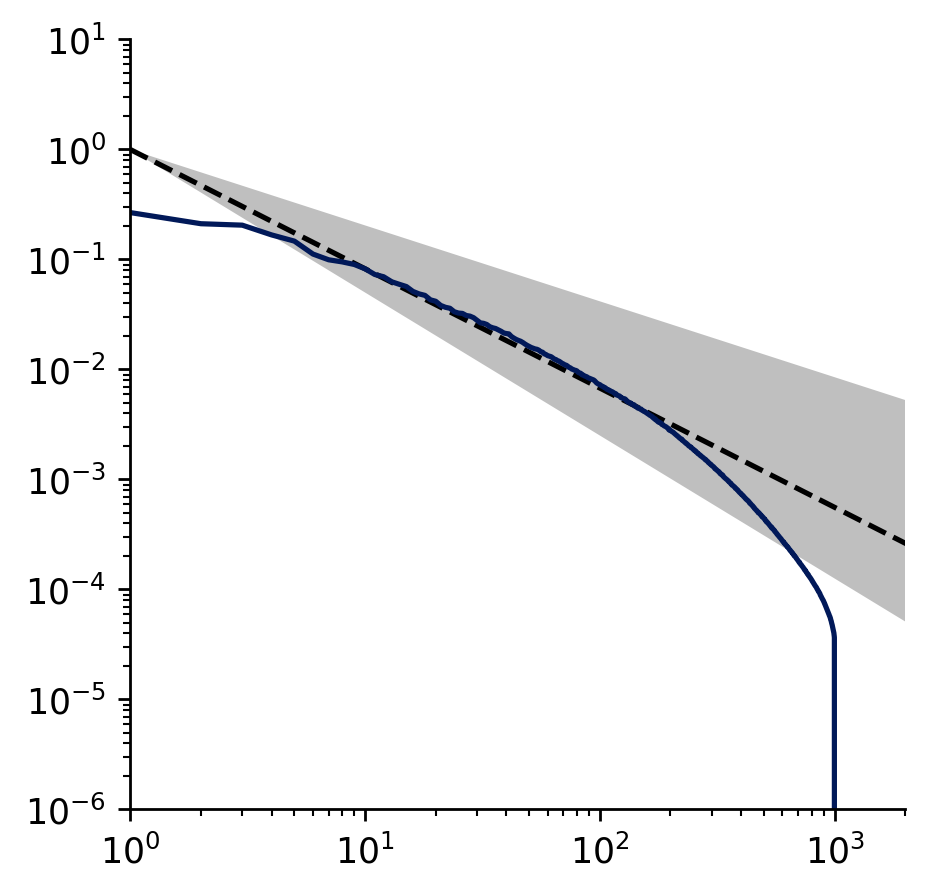

In [146]:
plt.figure(figsize=(4, 4), dpi=250)
plt.loglog(x, simulated, label="fit", ls="--", color="k")
plt.loglog(x, scaled_eig_cov, label="simulation", )

plt.fill_between(x, asym, sym, color="gray", alpha=0.5, edgecolor=None)

plt.xlim(1, 2000)
plt.ylim(0.000001, 10)

sns.despine()